# Preface

In this notebook, we implement the basic form of Neural Style Transfer. Also take note of the third way of build `keras` models besides the Sequential and Functional API, i.e. [model subclassing](https://www.tensorflow.org/guide/keras/custom_layers_and_models). 

*This notebook is based on https://www.tensorflow.org/tutorials/generative/style_transfer*

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import PIL.Image
import matplotlib.gridspec as gridspec

# Loading Content and Style Images

Let us first load our content and style images. We start with writing some handy functions.

In [2]:
def tensor_to_image(tensor):
    """Convert a tensor to a PIL image object
    """
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

def load_img(path_to_img):
    """Load image file file to a tf tensor
    """
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

In [3]:
content_path = './data/nus_science.jpg'
style_path = './data/starry_night.jpg'

In [4]:
content_image = load_img(content_path)
style_image = load_img(style_path)

Let us have a look at our images.

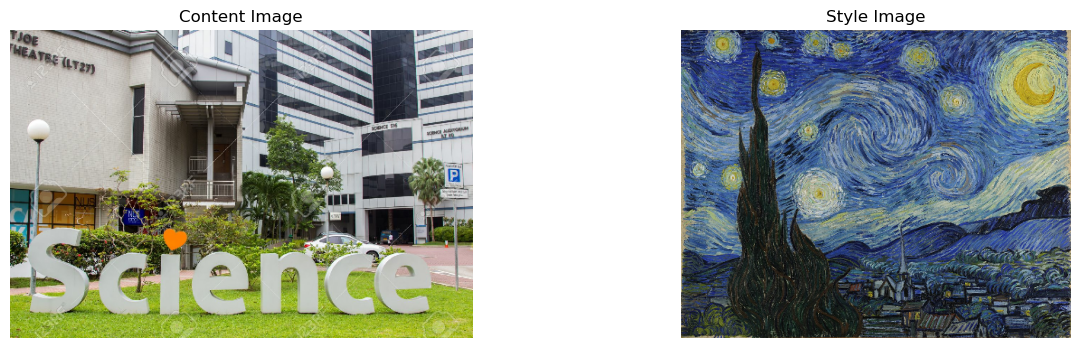

In [5]:
def plot_content_and_style_images():
    fig, ax = plt.subplots(1, 2, figsize=(15, 4))

    ax[0].imshow(content_image[0])
    ax[1].imshow(style_image[0])

    ax[0].set_title('Content Image')
    ax[1].set_title('Style Image')

    for a in ax:
        a.axis('off')

plot_content_and_style_images()

# Neural Style Transfer

## VGG To Extract Features

We will use the VGG network (pre-trained on ImageNet) as a form of feature extractors for these images. This can be done using the `tf.keras.applications` module.

In [6]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

for i, layer in enumerate(vgg.layers):
    print(f'Layer {i}: {layer.name}')

Layer 0: input_1
Layer 1: block1_conv1
Layer 2: block1_conv2
Layer 3: block1_pool
Layer 4: block2_conv1
Layer 5: block2_conv2
Layer 6: block2_pool
Layer 7: block3_conv1
Layer 8: block3_conv2
Layer 9: block3_conv3
Layer 10: block3_conv4
Layer 11: block3_pool
Layer 12: block4_conv1
Layer 13: block4_conv2
Layer 14: block4_conv3
Layer 15: block4_conv4
Layer 16: block4_pool
Layer 17: block5_conv1
Layer 18: block5_conv2
Layer 19: block5_conv3
Layer 20: block5_conv4
Layer 21: block5_pool


Our **content layer** shall be high level features, and we choose `block5_conv2`

In [7]:
content_layers = ['block5_conv2']
num_content_layers = len(content_layers)

**Style layers** will be lower level layers

In [8]:
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
num_style_layers = len(style_layers)

Now, we write a function that outputs a model with outputs a list of vgg layer names. 

In [9]:
def vgg_layers(layer_names):
    """Build models with outputs being VGG layers
    """
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False

    outputs = [vgg.get_layer(name).output for name in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

Since the style loss requires the Gram matrix computation of features
$$
    G_{i j}^{(\ell)}=\sum_{k} h_{i k}^{(\ell)} h_{j k}^{(\ell)},
$$
we will write a custom function to do this. For convenience, we will use the `tf.linalg.einsum` function to choose which indices to sum over. This is based on the *Einstein summation notation*. You can read more about it [here](https://en.wikipedia.org/wiki/Einstein_notation).

In [10]:
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1] * input_shape[2], tf.float32)
    return result / (num_locations)

We now put things together by building a model that we can easily compute the content loss and the style loss. We will use *model subclassing* function of `keras`, which is the most flexible way of building models. 

This can be done by inheriting the `tf.keras.models.Model` class, and we will implement the `model.__call__` method, which controls the behavior of `model(x)` for some input `x`.

**Remarks**
  * The `tf.keras.applications.vgg19.preprocess_input` function processes the input images to the form that is usable by VGG

In [11]:
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg = vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False  # We don't train the weights

    def call(self, inputs):
        inputs = inputs * 255.0  # we expect input pixels to be between 0 and 1
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                          outputs[self.num_style_layers:])
        # Compute the Gram-matrices representing styles
        style_outputs = [gram_matrix(style_output) for style_output in style_outputs]

        # Build dictionaries containing contents and styles
        # to be returned by the model's call method
        content_dict = {
            content_name: value
            for content_name, value in zip(self.content_layers,
                                           content_outputs)
        }

        style_dict = {
            style_name: value
            for style_name, value in zip(self.style_layers, style_outputs)
        }

        return {'content': content_dict, 'style': style_dict}

In [12]:
extractor = StyleContentModel(style_layers, content_layers)

## Building Style and Content Losses

We first obtain the style and content targets from the style and content images respectively

In [13]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

For the new image $x$ to be produced, we will need to update it by gradient descent. For this reason, we will put it into a `tf.Variable` object, initialized with the content image.

In [14]:
image = tf.Variable(content_image)

Now, we define the content and style losses
$$
    E_{c}\left(x, x_{c}, \ell\right)=\frac{1}{2} \sum_{i, j}\left(h_{i j}^{(\ell)}(x)-h_{i j}^{(\ell)}\left(x_{c}\right)\right)^{2} \\
    L_{c}\left(\boldsymbol{x}, \boldsymbol{x}_{c}\right)=\sum_{\ell \in \ell_{c}} E_{c}\left(\boldsymbol{x}, \boldsymbol{x}_{c}, l\right) \\
    E_{s}\left(\boldsymbol{x}, \boldsymbol{x}_{s}, \ell\right)=\frac{1}{4 N_{l} M_{l}} \sum_{i, j}\left(G_{i j}^{(\ell)}(\boldsymbol{x})-G_{i j}^{(\ell)}\left(\boldsymbol{x}_{s}\right)\right)^{2} \\
    L_{s}\left(\boldsymbol{x}, \boldsymbol{x}_{\boldsymbol{s}}\right)=\sum_{\ell \in \ell_{s}} E_{s}\left(\boldsymbol{x}, \boldsymbol{x}_{\boldsymbol{s}} ; \ell\right)
$$

In [15]:
def style_content_loss(outputs):
    style_weight=1e-2
    content_weight=1e4
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([
        tf.reduce_mean((style_outputs[name] - style_targets[name])**2)
        for name in style_outputs.keys()
    ])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([
        tf.reduce_mean((content_outputs[name] - content_targets[name])**2)
        for name in content_outputs.keys()
    ])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

## Training to Transfer Styles

In [16]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [17]:
def clip_0_1(image):
    """Clips image to 0-1
    """
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

As before, since we are optimizing over the inputs, we can make use of the eager execution feature of tensorflow via the `tf.GradientTape()` function. 

Once the gradients are computed, we can then apply them using the `opt.apply_gradients` method, which is available for all `keras` optimizer objects.

**Remarks**
The `@tf.function` decorator may speed up performance of custom python functions by creating a tf graph for it. For more details you can read [here](https://www.tensorflow.org/guide/function).

In [18]:
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

Finally, we train the model by calling `train_step` repeatedly.

In [20]:
from tqdm import tqdm

n_iters = 1000

for _ in tqdm(range(n_iters)):
    train_step(image)
    
np.save('./nus_science_plus_starry_night', image.numpy())

100%|██████████| 1000/1000 [20:04<00:00,  1.20s/it]


Finally, let us look at the result!

In [21]:
image = np.load('./nus_science_plus_starry_night.npy')

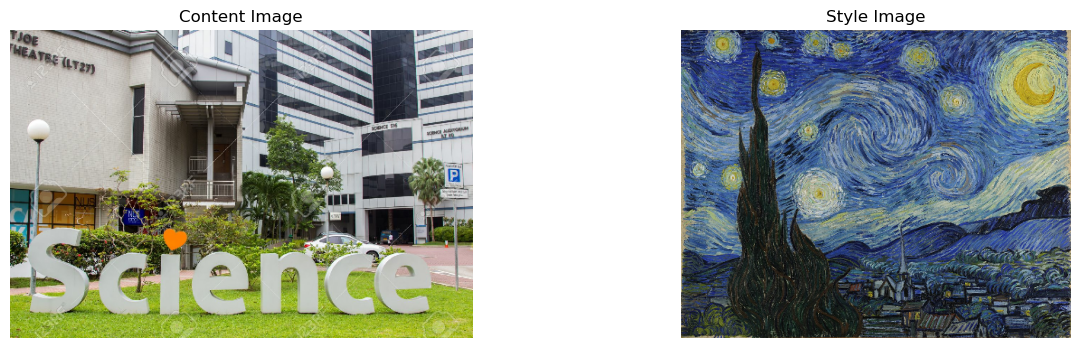

In [22]:
plot_content_and_style_images()

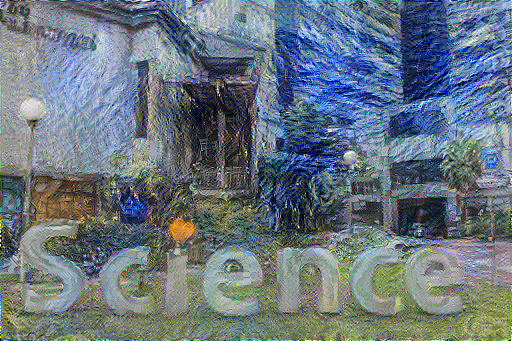

In [23]:
tensor_to_image(image)

# Exercise

1. Try other style and content images for fun!
2. Can you do the same for other types of data, other than images?